In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
from torchmetrics.classification import CalibrationError

def calculate_ece(predictions, labels, n_bins=10):
    ece_metric = CalibrationError(n_bins=n_bins, norm='l1', task="multiclass", num_classes=4)
    
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    
    ece = ece_metric(predictions_tensor, labels_tensor)
    
    return ece.item()

# Load model

In [5]:
import torch
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM

# model_id = "meta-llama/Meta-Llama-3-8B"
# model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "huggyllama/llama-7b"
# model_id = "facebook/opt-13b"
model_id = "meta-llama/Llama-2-7b-hf"


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.float16,
)


/home/djaniak/mambaforge/envs/info/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/djaniak/mambaforge/envs/info/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Load dataset

Please pick one among the available configs: 
['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']

In [6]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
dataset["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

# Train linear probing classifier on top of the hidden states

In [22]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np

def extract_data(dataset, model, tokenizer, device, text_column, target_column, aggregate = "mean"):
    X = defaultdict(list)
    y = []

    for example in tqdm(dataset):
        inputs = tokenizer(example[text_column], return_tensors='pt', truncation=True, max_length=2048).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            for i, hs in enumerate(outputs.hidden_states):
                X[i].append(hs.squeeze().cpu())
                # if aggregate == "mean":
                #     X[i].append(hs.squeeze().mean(dim=0).cpu())
                # elif aggregate == "last_token":
                #     X[i].append(hs.squeeze()[-1,:].cpu())
                # else:
                #     raise ValueError(f"Unknown aggregation method: {aggregate}")
            y.append(example[target_column])

    # for k, v in X.items():
    #     X[k] = torch.stack(v)

    return X, y


In [29]:
text_column = 'text'
target_column = 'label'
aggregate = 'mean'
N = 2000

tr_data = dataset['train'].shuffle(seed=42).select(range(N))
te_data = dataset['train'].shuffle(seed=42).select(range(N, N+N//5))

In [44]:
tr_data[:2]

{'text': ['There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...',
  'This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It

In [45]:
te_data[:2]

{'text': ["This film features Ben Chaplin as a bored bank employee in England who orders a mail order bride from Russia, recieves Nicole Kidman in the mail and gets more than he bargained for when, surprise, she isn't what she appears to be. The story is fairly predictible and Chaplin underacts too much to the point where he becomes somewhat anoying. Kidman is actualy rather good in this role, making her character about the only thing in this film that is interesting. GRADE: C",
  'By no means a masterpiece, and far from Errol Flynn\'s best, Istanbul still has much going for it. The locations and beautiful technicolour cinematography, bring us back to a time long since past. Errol Flynn does show moments of his past glory, and is OK as Jim Brennan, a pilot who\'s past comes back to haunt him. The picture is actually a remake of 1947\'s "Singapore", and the story seems awfully contrived and cliche\' by today\'s standards. Also many of the supporting cast seem to be simply "going through

In [30]:
tr_features, tr_labels = extract_data(tr_data, model, tokenizer, device, text_column, target_column)
te_features, te_labels = extract_data(te_data, model, tokenizer, device, text_column, target_column)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:55<00:00,  7.17it/s]


In [31]:
len(tr_features[0]), len(te_features[0]), len(tr_labels), len(te_labels)

(2000, 400, 2000, 400)

In [33]:
import numpy as np

np.unique(tr_labels, return_counts=True)

(array([0, 1]), array([1000, 1000]))

## Mean token aggregate

In [57]:
from sklearn.linear_model import LogisticRegression
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import accuracy_score

bce = BinaryCalibrationError(n_bins=10, norm='l1')

mean_token_results = []

for i, (tr_feat, te_feat) in enumerate(zip(tr_features.values(), te_features.values())):
    lr = LogisticRegression(max_iter=1000)
    mean_tr_feat = torch.stack([feat.mean(dim=0) for feat in tr_feat])  # mean over tokens
    lr.fit(mean_tr_feat, tr_labels)

    tr_probs = lr.predict_proba(mean_tr_feat)
    tr_pred = np.argmax(tr_probs, axis=1)
    # tr_pred = lr.predict(tr_feat)
    tr_acc = round(accuracy_score(tr_labels, tr_pred), 3)
    tr_ece = round(bce(torch.tensor(tr_probs)[:,1], torch.tensor(tr_labels)).item(), 3)

    mean_te_feat = torch.stack([feat.mean(dim=0) for feat in te_feat])  # mean over tokens
    te_probs = lr.predict_proba(mean_te_feat) 
    te_pred = np.argmax(te_probs, axis=1)
    te_acc = round(accuracy_score(te_pred, te_labels), 3)
    te_ece = round(bce(torch.tensor(te_probs)[:,1], torch.tensor(te_labels)).item(), 3)

    mean_token_results.append({"tr_acc": tr_acc, "tr_ece": tr_ece, "test_acc": te_acc, "test_ece": te_ece, "hidden_state": i})
    print(f"Block {i}th; train - acc: {tr_acc}, ece {tr_ece}; test - acc: {te_acc}, ece: {te_ece}")



Block 0th; train - acc: 0.738, ece 0.227; test - acc: 0.715, ece: 0.205
Block 1th; train - acc: 0.744, ece 0.203; test - acc: 0.725, ece: 0.185
Block 2th; train - acc: 0.79, ece 0.193; test - acc: 0.733, ece: 0.138
Block 3th; train - acc: 0.831, ece 0.174; test - acc: 0.795, ece: 0.155
Block 4th; train - acc: 0.877, ece 0.153; test - acc: 0.85, ece: 0.147
Block 5th; train - acc: 0.919, ece 0.115; test - acc: 0.89, ece: 0.102
Block 6th; train - acc: 0.94, ece 0.094; test - acc: 0.902, ece: 0.088
Block 7th; train - acc: 0.954, ece 0.075; test - acc: 0.932, ece: 0.082
Block 8th; train - acc: 0.964, ece 0.063; test - acc: 0.938, ece: 0.059
Block 9th; train - acc: 0.975, ece 0.055; test - acc: 0.94, ece: 0.041
Block 10th; train - acc: 0.98, ece 0.048; test - acc: 0.948, ece: 0.045
Block 11th; train - acc: 0.988, ece 0.041; test - acc: 0.948, ece: 0.044
Block 12th; train - acc: 0.991, ece 0.037; test - acc: 0.945, ece: 0.019
Block 13th; train - acc: 0.993, ece 0.036; test - acc: 0.95, ece: 0

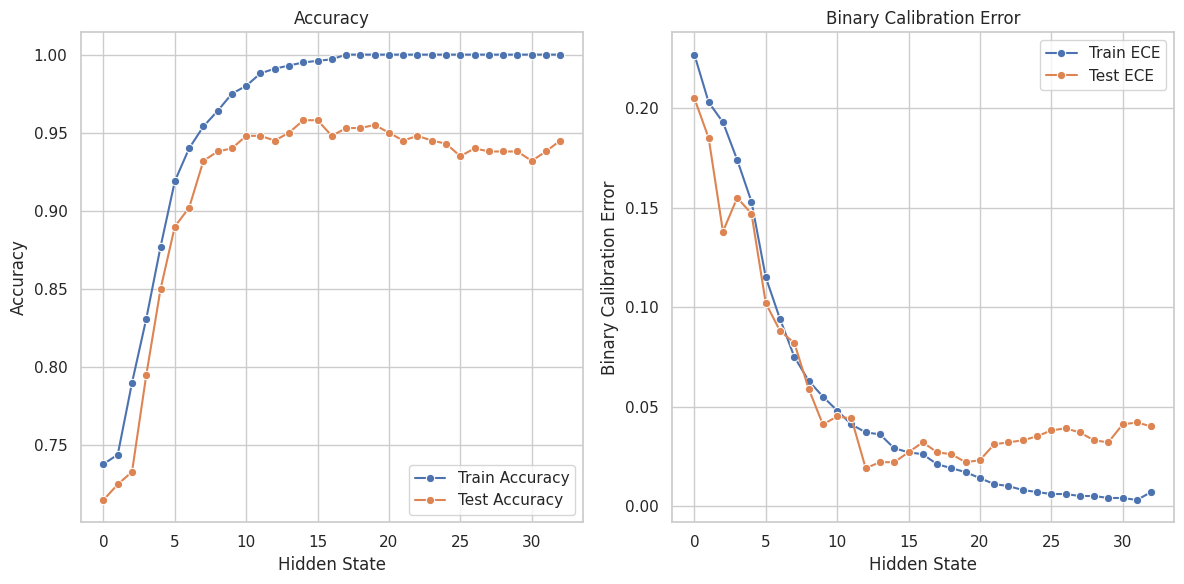

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_mean_tokens = pd.DataFrame(mean_token_results)

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_mean_tokens, x='hidden_state', y='tr_acc', ax=axes[0], marker='o', label='Train Accuracy')
sns.lineplot(data=df_mean_tokens, x='hidden_state', y='test_acc', ax=axes[0], marker='o', label='Test Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Hidden State')

sns.lineplot(data=df_mean_tokens, x='hidden_state', y='tr_ece', ax=axes[1], marker='o', label='Train ECE')
sns.lineplot(data=df_mean_tokens, x='hidden_state', y='test_ece', ax=axes[1], marker='o', label='Test ECE')
axes[1].set_title('Binary Calibration Error')
axes[1].set_ylabel('Binary Calibration Error')
axes[1].set_xlabel('Hidden State')

plt.tight_layout()
plt.show()

## Last token aggregation

In [56]:
from sklearn.linear_model import LogisticRegression
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import accuracy_score

bce = BinaryCalibrationError(n_bins=10, norm='l1')

last_token_results = []

for i, (tr_feat, te_feat) in enumerate(zip(tr_features.values(), te_features.values())):
    lr = LogisticRegression(max_iter=2000)
    mean_tr_feat = torch.stack([feat[-1] for feat in tr_feat])
    lr.fit(mean_tr_feat, tr_labels)

    tr_probs = lr.predict_proba(mean_tr_feat)
    tr_pred = np.argmax(tr_probs, axis=1)
    # tr_pred = lr.predict(tr_feat)
    tr_acc = round(accuracy_score(tr_labels, tr_pred), 3)
    tr_ece = round(bce(torch.tensor(tr_probs)[:,1], torch.tensor(tr_labels)).item(), 3)

    mean_te_feat = torch.stack([feat[-1] for feat in te_feat]) 
    te_probs = lr.predict_proba(mean_te_feat) 
    te_pred = np.argmax(te_probs, axis=1)
    te_acc = round(accuracy_score(te_pred, te_labels), 3)
    te_ece = round(bce(torch.tensor(te_probs)[:,1], torch.tensor(te_labels)).item(), 3)

    last_token_results.append({"tr_acc": tr_acc, "tr_ece": tr_ece, "test_acc": te_acc, "test_ece": te_ece, "hidden_state": i})
    print(f"Block {i}th; train - acc: {tr_acc}, ece {tr_ece}; test - acc: {te_acc}, ece: {te_ece}")



Block 0th; train - acc: 0.574, ece 0.029; test - acc: 0.54, ece: 0.022
Block 1th; train - acc: 0.709, ece 0.124; test - acc: 0.665, ece: 0.084
Block 2th; train - acc: 0.783, ece 0.149; test - acc: 0.703, ece: 0.078
Block 3th; train - acc: 0.848, ece 0.147; test - acc: 0.723, ece: 0.065
Block 4th; train - acc: 0.903, ece 0.131; test - acc: 0.802, ece: 0.074
Block 5th; train - acc: 0.968, ece 0.103; test - acc: 0.835, ece: 0.04
Block 6th; train - acc: 0.991, ece 0.079; test - acc: 0.848, ece: 0.057
Block 7th; train - acc: 0.999, ece 0.055; test - acc: 0.85, ece: 0.06
Block 8th; train - acc: 1.0, ece 0.041; test - acc: 0.86, ece: 0.049
Block 9th; train - acc: 1.0, ece 0.026; test - acc: 0.87, ece: 0.059
Block 10th; train - acc: 1.0, ece 0.019; test - acc: 0.885, ece: 0.057
Block 11th; train - acc: 1.0, ece 0.013; test - acc: 0.905, ece: 0.058
Block 12th; train - acc: 1.0, ece 0.01; test - acc: 0.907, ece: 0.052
Block 13th; train - acc: 1.0, ece 0.009; test - acc: 0.917, ece: 0.045
Block 1

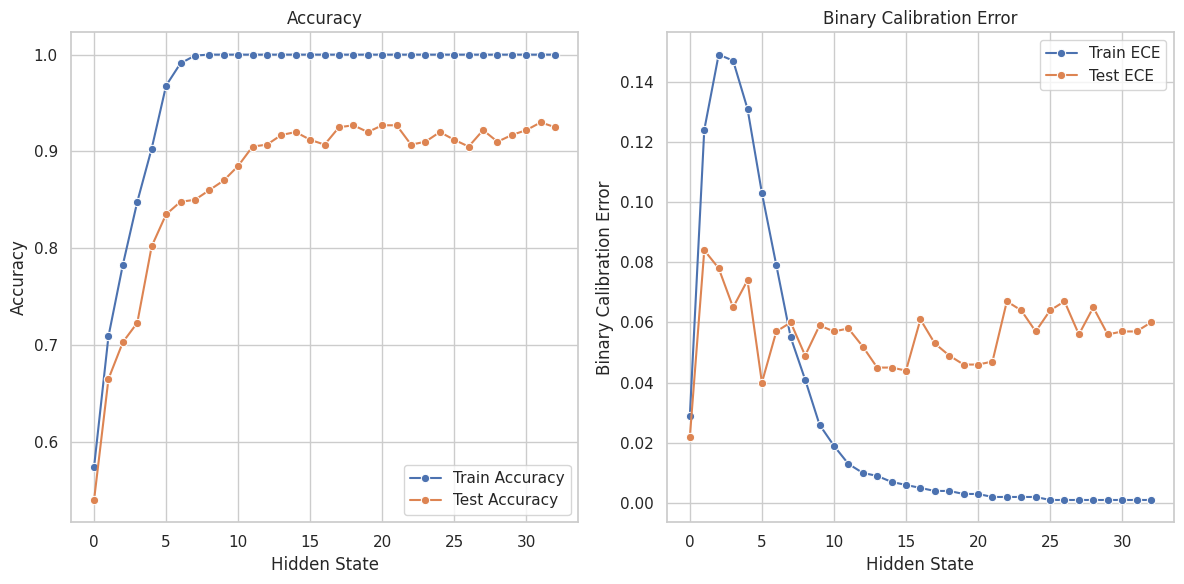

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_last_tokens = pd.DataFrame(last_token_results)

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_last_tokens, x='hidden_state', y='tr_acc', ax=axes[0], marker='o', label='Train Accuracy')
sns.lineplot(data=df_last_tokens, x='hidden_state', y='test_acc', ax=axes[0], marker='o', label='Test Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Hidden State')

sns.lineplot(data=df_last_tokens, x='hidden_state', y='tr_ece', ax=axes[1], marker='o', label='Train ECE')
sns.lineplot(data=df_last_tokens, x='hidden_state', y='test_ece', ax=axes[1], marker='o', label='Test ECE')
axes[1].set_title('Binary Calibration Error')
axes[1].set_ylabel('Binary Calibration Error')
axes[1].set_xlabel('Hidden State')

plt.tight_layout()
plt.show()

# Compare mean vs last

In [60]:
df_last_tokens["agg_token"] = "last"
df_mean_tokens["agg_token"] = "mean"

df_concat = pd.concat([df_last_tokens, df_mean_tokens])

In [65]:
df_concat.head()

,tr_acc,tr_ece,test_acc,test_ece,hidden_state,agg_token
0,0.574,0.029,0.540,0.022,0,last
1,0.709,0.124,0.665,0.084,1,last
2,0.783,0.149,0.703,0.078,2,last
3,0.848,0.147,0.723,0.065,3,last
4,0.903,0.131,0.802,0.074,4,last


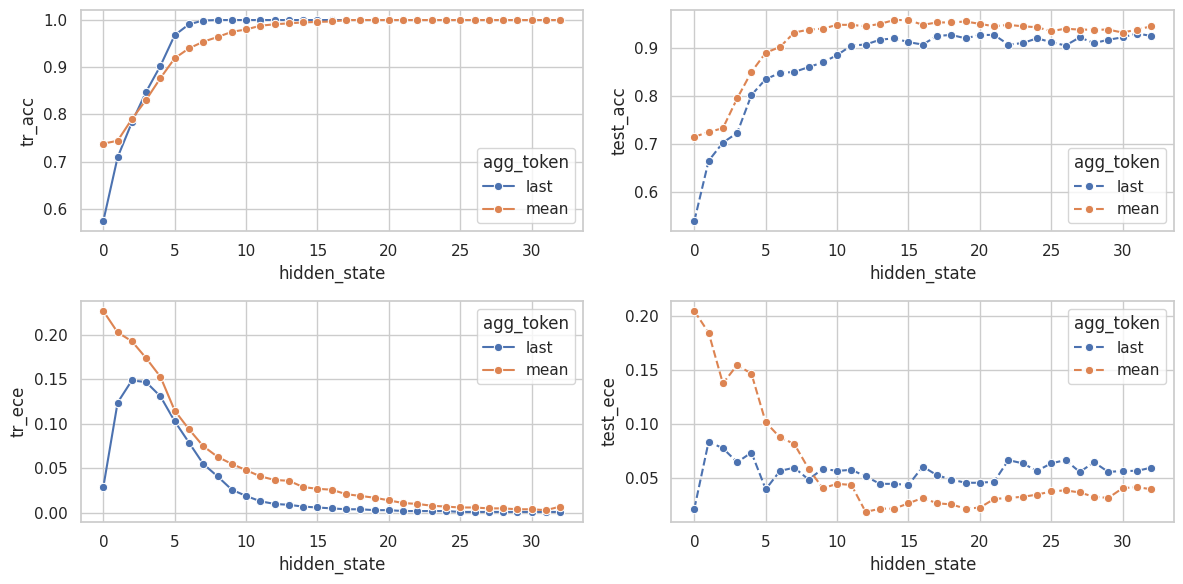

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.lineplot(data=df_concat, x='hidden_state', y='tr_acc', hue='agg_token', ax=axes[0][0], marker='o')
sns.lineplot(data=df_concat, x='hidden_state', y='test_acc', hue='agg_token', ax=axes[0][1], marker='o', linestyle='--')

sns.lineplot(data=df_concat, x='hidden_state', y='tr_ece', hue='agg_token', ax=axes[1][0], marker='o')
sns.lineplot(data=df_concat, x='hidden_state', y='test_ece', hue='agg_token', ax=axes[1][1], marker='o', linestyle='--')

plt.tight_layout()
plt.show()

# Entropy

In [70]:
from src.matrix_entropy import compute_entropies_for_each_sentence
from torch.utils.data import DataLoader

def get_dataloader(dataset, target_column, remove_columns, max_length=2048, seed=42):
    def tokenize_function(examples):
        return tokenizer(examples[target_column], truncation=True, max_length=max_length)

    tokenized_dataset = dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
    tokenized_dataset = tokenized_dataset.remove_columns(remove_columns)
    tokenized_dataset.set_format("torch")

    dataloader = DataLoader(tokenized_dataset, shuffle=False)
    return dataloader

remove_columns = ["text", "label"]
target_column = "text"

tr_dataloader = get_dataloader(tr_data, target_column, remove_columns)
te_dataloader = get_dataloader(te_data, target_column, remove_columns)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [71]:
tr_entropies = compute_entropies_for_each_sentence(
    model, tr_dataloader, alpha=1, device=device
)
te_entropies = compute_entropies_for_each_sentence(
    model, te_dataloader, alpha=1, device=device
)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:00<00:00,  3.32it/s]


In [72]:
from src.utils import get_metric


def get_mean_entropies(entropies):
    mean_entropies = {}
    hidden_states = entropies["unnormalized_entropy"].keys()
    for e in [
                "logN_normalized_entropy",
                "logD_normalized_entropy",
                "NlogD_normalized_entropy",
                "logNlogD_normalized_entropy",
            ]:
        es = []
        for hs in hidden_states:
            es.append(np.mean(get_metric(entropies, e, hidden_state=hs)))
        mean_entropies[e] = es
    return mean_entropies

mean_tr_entropies = get_mean_entropies(tr_entropies)
mean_te_entropies = get_mean_entropies(te_entropies)

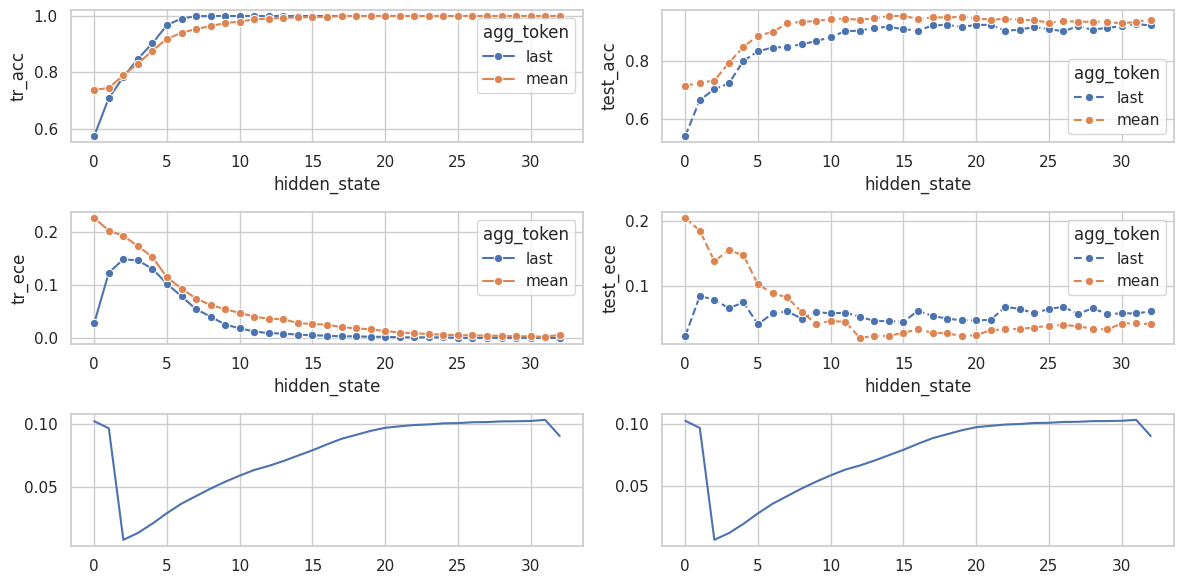

In [75]:
import matplotlib.pyplot as plt


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(12, 6))

sns.lineplot(data=df_concat, x='hidden_state', y='tr_acc', hue='agg_token', ax=axes[0][0], marker='o')
sns.lineplot(data=df_concat, x='hidden_state', y='test_acc', hue='agg_token', ax=axes[0][1], marker='o', linestyle='--')

sns.lineplot(data=df_concat, x='hidden_state', y='tr_ece', hue='agg_token', ax=axes[1][0], marker='o')
sns.lineplot(data=df_concat, x='hidden_state', y='test_ece', hue='agg_token', ax=axes[1][1], marker='o', linestyle='--')


entropy = "logNlogD_normalized_entropy"
axes[2,0].plot(range(len(mean_tr_entropies[entropy])), mean_tr_entropies[entropy], label=f'Train {entropy}')
axes[2,1].plot(range(len(mean_te_entropies[entropy])), mean_te_entropies[entropy], label=f'Test {entropy}')

plt.tight_layout()
plt.show()

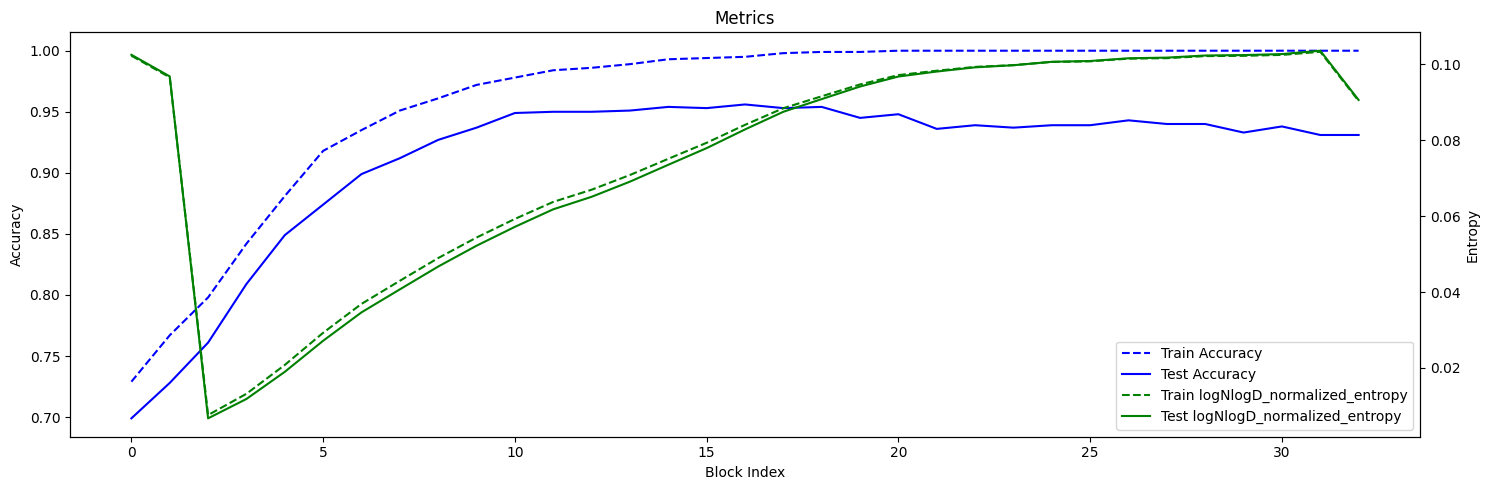

In [ ]:
# Plot the results
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

# Plot Accuracy
ax1.plot(range(len(results)), tr_accs, label='Train Accuracy', linestyle='--', color='blue')
ax1.plot(range(len(results)), te_accs, label='Test Accuracy', linestyle='-', color='blue')

# Plot Mean Entropies
entropy = "logNlogD_normalized_entropy"
ax2.plot(range(len(mean_tr_entropies[entropy])), mean_tr_entropies[entropy], label=f'Train {entropy}',linestyle='--', color='green')
ax2.plot(range(len(mean_te_entropies[entropy])), mean_te_entropies[entropy], label=f'Test {entropy}', color='green')

ax1.set_xlabel('Block Index')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Entropy')
plt.title('Metrics')

ax1.tick_params(axis='y')

ax2.tick_params(axis='y')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.tight_layout()
plt.show()